[9.9651888e-04 1.6605970e-03 3.7369274e-03 3.6693294e-02 1.9883974e-01
 1.6960467e+00]
[1.3640032e-03 2.8056893e-03 6.0631270e-03 5.5506077e-02 3.6719146e-01
 3.3807566e+00]
[9.7003430e-03 5.6492306e-02 1.7348217e+00 7.8101517e+01 2.7669497e+03
           nan]


/var/folders/7_/0653nqtd429drk6gpgkqq25h0000gn/T/ipykernel_85641/3435888491.py:23: RuntimeWarning: Mean of empty slice.
  means[k] = vals.mean()


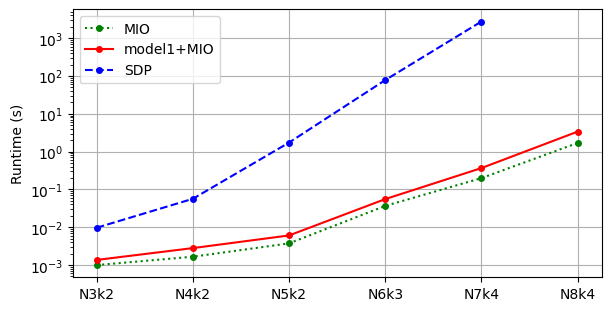

In [50]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

colors = {'sdp':'blue', 'mio_cdae':'green', 'mio_cdae_mio':'red'}
labels = {'sdp':'SDP', 'mio_cdae_mio':'model1+MIO', 'mio_cdae':'MIO'}
line_style = {'sdp':'--', 'mio_cdae':':', 'mio_cdae_mio':'-'}

with h5py.File('runtimes.h5', 'r') as f:

    fig, (ax) = plt.subplots(1, 1, layout="constrained", figsize=(6, 3))
    
    keys = [key for key in f.keys()]

    for key in keys:
        color = colors[key]
        
        means = {}
        stds = {}
        for k,v in f[key].items():
            vals = v[:][v[:]>0]
            # print(key,k,len(vals))
            means[k] = vals.mean()
            stds[k] = vals.std()
        # means  = {k:v[:].mean() for k,v in f[key].items() if not v[:].mean() == 0 }
        # stds   = {k:v[:].std() for k,v in f[key].items() if not v[:].mean() == 0 }
        
        means_arr = np.array(list(means.values()))
        print(means_arr)
        stds_arr = np.array(list(stds.values()))
        ax.semilogy(means.keys(), means_arr, line_style[key], marker='o', markersize = 4,label=labels[key], c=color)
        # ax.scatter(means.keys(), means_arr, s=20, c=color)
        # ax.plot(means.keys(), means_arr, line_style[key],label=labels[key], c=color)   
        # ax.fill_between(means.keys(), means_arr - stds_arr, means_arr + stds_arr, alpha=0.15, color=color)
    
ax.grid()
ax.set_yscale('log')
ax.set_ylabel('Runtime (s)')
ax.legend(loc='upper left')
path = f'./plots/runtime.png'
plt.savefig(path, bbox_inches='tight', transparent=True)
plt.show()

In [20]:
means_arr

array([9.7003430e-03, 5.6492306e-02, 1.7348217e+00, 7.8101517e+01,
       2.7669497e+03,           nan], dtype=float32)

In [3]:
full_data = {}

with h5py.File('fidelities_benchmark.h5', 'r') as f:
    for key in f.keys():  #models 
        full_data[key] = {'fidelities':{}, 'success_rate':{},'runtime': {}}
        for metric,v in f[key].items():  #metrics
            full_data[key][metric] = {}
            for k1,v1 in v.items():
                case = (int(k1[1]), int(k1[3]))
                # print(f'case: {case}')
                full_data[key][metric][case] = {int(k2): v2[:] for k2,v2 in v1.items()}


In [5]:
import pandas as pd
from utils_benchmark import (
    PlotData,
    plot_std
)

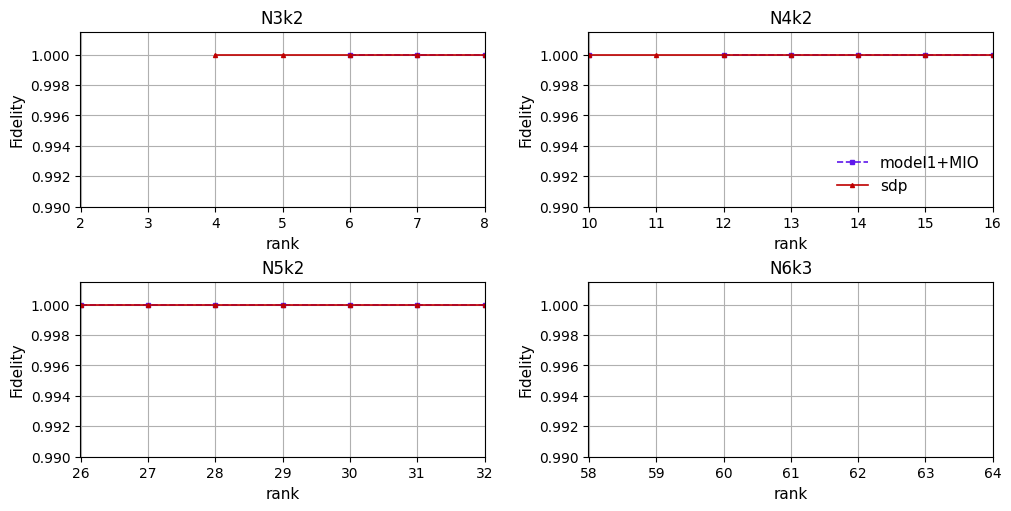

In [18]:
# cases = [(3,2),(4,2),(5,2)]#,(5,4)]

cases = [(3,2),(4,2),(5,2),(6,3)]
str_extra_mio = 'yes'
ncols = 2


nrows = int(np.ceil(len(cases)/ncols).item())
rows_idxs, columns_idxs = np.indices((nrows,ncols)).reshape(2,-1)[0], np.indices((nrows,ncols)).reshape(2,-1)[1]

# fig, axs = plt.subplots(ncols=ncols, nrows=nrows,figsize=(16,4), 
#                         layout="constrained",gridspec_kw={'hspace': 0.0, 'wspace': 0.05})

fig, axs = plt.subplots(ncols=ncols, nrows=nrows,figsize=(10,5), 
                        layout="constrained",gridspec_kw={'hspace': 0.0, 'wspace': 0.05})

for (i,j),(N,k) in zip(zip(rows_idxs, columns_idxs),cases):
    dn = 2**N
    min_rank = dn - 6

    mio_cdae = pd.DataFrame.from_dict(full_data['mio_cdae_mio']['fidelities'][(N,k)])
    sdp = pd.DataFrame.from_dict(full_data['sdp']['fidelities'][(N,k)])
    # rg = pd.DataFrame.from_dict(full_data['random_guessing']['success_rate'][(N,k)])
    
    if str_extra_mio == 'yes':
         mio_str = '+MIO'
    else:
        mio_str = ''
       
    
    data_to_plot_mio_cdae = PlotData(mio_cdae,
                                   f'model1{mio_str}',
                                   '#5e17eb',
                                   marker='s',
                                   linestyle='--')
    
    data_to_plot_sdp = PlotData(sdp,
                               'sdp',
                               '#bf0000',
                               marker='^',
                               linestyle='-')
    
    # data_to_plot_rg = PlotData(rg,
    #                            'random\nguessing',
    #                            'g',
    #                            marker='o',
    #                            linestyle=':')

    # path = f'{current_working_directory}/plots/all_cases_extra_mio_{str_extra_mio}.png'
    
    if str_extra_mio == 'no':
        ylim_min = 0.0
        ylim_max = 1.01
    else:
        ylim_min = 0.99
        ylim_max = 1.0015

    axs[i,j].set_title(f'N{N}k{k}', fontsize=12) 
    # data_to_plot_mio_cdae,data_to_plot_rg,data_to_plot_sdp
    plot_std(axs[i,j],[data_to_plot_mio_cdae,data_to_plot_sdp], 
                    ylims=[ylim_min,ylim_max],
                    xlims=[dn-6-1e-2,dn + 1e-2], 
                    pathplot='',
                    legen_loc='lower right',
                    xlabel='')
    # axs[i,j].set_xticks(np.arange(dn-6,dn+1,1))
    # xticks = [f'$2^N - {i}$' for i in range(6,-1,-1)]
    # xticks[-1] = f'$2^N$'
    # axs[i,j].set_xticks(np.arange(dn-6,dn+1,1), xticks)

axs[0,ncols-1].legend(loc='lower right', fontsize=11, frameon=False)

for ax in axs.flat:
    # ax.set(xlabel='rank', ylabel='Fidelity')
    ax.set_xlabel('rank', fontsize=11)
    ax.set_ylabel('Fidelity', fontsize=11)
    # ax.label_outer()
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid()

plt.savefig(path, bbox_inches='tight', transparent=True)
plt.show()

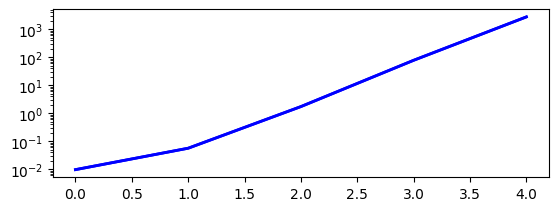

In [42]:
import matplotlib.pyplot as plt
a = [pow(10, i) for i in range(10)]
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(means_arr, color='blue', lw=2)

ax.semilogy(means_arr, color='blue', lw=2)
# ax.set_yscale('log')

plt.show()

In [38]:
np.log(means_arr)

array([-4.635594  , -2.8736508 ,  0.55090463,  4.3580093 ,  7.925501  ,
               nan], dtype=float32)

In [39]:
means_arr

array([9.7003430e-03, 5.6492306e-02, 1.7348217e+00, 7.8101517e+01,
       2.7669497e+03,           nan], dtype=float32)